In [42]:
import os
import time
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspe
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

import ccxt

%matplotlib inline

path=os.getcwd()
os.chdir(path)
path

binance=ccxt.binance()
btc_ohlcv = binance.fetch_ohlcv("BTC/USDT",'1d')

df = pd.DataFrame(btc_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
df=df[['time', 'close']]
df['time'] = pd.to_datetime(df['time'], unit='ms')
print(df)

          time     close
0   2021-06-20  35600.16
1   2021-06-21  31608.93
2   2021-06-22  32509.56
3   2021-06-23  33678.07
4   2021-06-24  34663.09
..         ...       ...
495 2022-10-28  20591.84
496 2022-10-29  20809.67
497 2022-10-30  20627.48
498 2022-10-31  20490.74
499 2022-11-01  20534.75

[500 rows x 2 columns]


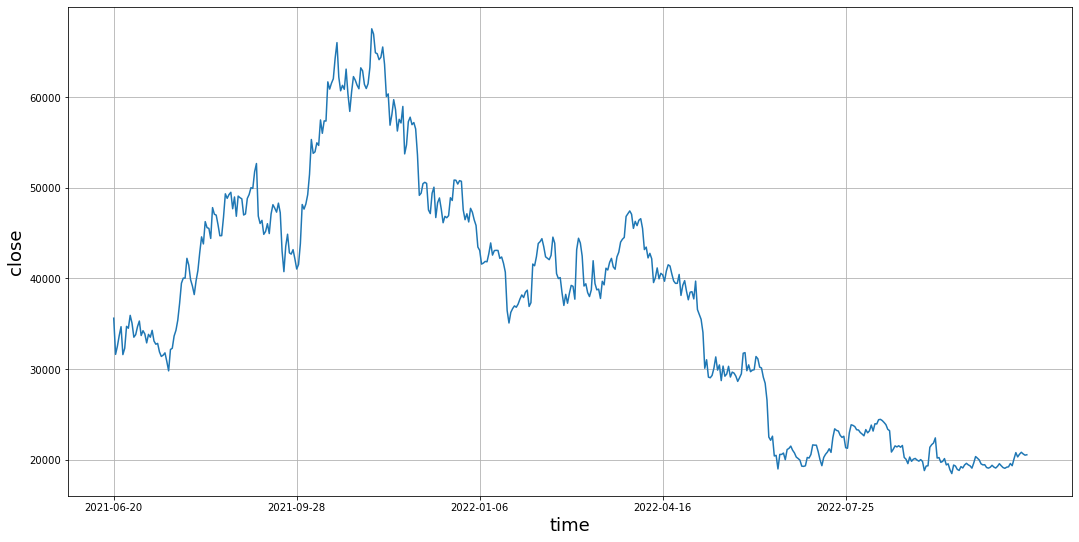

In [43]:
plt.figure(figsize = (18,9))
stock = df.copy()
plt.plot(df['time'].to_list(), df['close'].to_list())
plt.xlabel('time',fontsize=18)
plt.ylabel('close',fontsize=18)
plt.xticks(ticks=stock['time'].to_list())
plt.locator_params(axis='x', nbins=len(df)/100)
plt.grid(True)
plt.show()

In [44]:
train_data = df.loc[:100, 'close'].to_frame()
test_data = df.loc[100:, 'close'].to_frame()
train_data

,close
0,35600.16
1,31608.93
2,32509.56
3,33678.07
4,34663.09
...,...
96,42810.57
97,42670.64
98,43160.90
99,42147.35


In [45]:
def create_one_data(data):
    scaler = MinMaxScaler()
    train_data=data.loc[:100,'close'].to_frame()
    test_data = data.loc[100:, 'close'].to_frame()
    train_data_sc=scaler.fit_transform(train_data)
    test_data_sc=scaler.fit_transform(test_data)
    train_sc_df = pd.DataFrame(train_data_sc, columns=['Scaled'], index=train_data.index)
    test_sc_df = pd.DataFrame(test_data_sc, columns=['Scaled'], index=test_data.index)
    
    for i in range(1, 5):
        train_sc_df['Scaled_{}'.format(i)]=train_sc_df ['Scaled'].shift(i)
        test_sc_df['Scaled_{}'.format(i)]=test_sc_df ['Scaled'].shift(i)
    x_train=train_sc_df.dropna().drop('Scaled', axis=1)
    y_train=train_sc_df.dropna()[['Scaled']]

    x_test=test_sc_df.dropna().drop('Scaled', axis=1)
    y_test=test_sc_df.dropna()[['Scaled']]
    
    print(x_train)
    

In [46]:
create_one_data(df)
# x_train

     Scaled_1  Scaled_2  Scaled_3  Scaled_4
4    0.169966  0.118880  0.079506  0.253997
5    0.213029  0.169966  0.118880  0.079506
6    0.078436  0.213029  0.169966  0.118880
7    0.109004  0.078436  0.213029  0.169966
8    0.214658  0.109004  0.078436  0.213029
..        ...       ...       ...       ...
96   0.659054  0.601274  0.478458  0.578191
97   0.569226  0.659054  0.601274  0.478458
98   0.563108  0.569226  0.659054  0.601274
99   0.584542  0.563108  0.569226  0.659054
100  0.540231  0.584542  0.563108  0.569226

[97 rows x 4 columns]


In [47]:
scaler = MinMaxScaler()
train_data_sc=scaler.fit_transform(train_data)
test_data_sc= scaler.transform(test_data)

In [48]:
train_sc_df = pd.DataFrame(train_data_sc, columns=['Scaled'], index=train_data.index)
test_sc_df = pd.DataFrame(test_data_sc, columns=['Scaled'], index=test_data.index)

for i in range(1, 5):
    train_sc_df ['Scaled_{}'.format(i)]=train_sc_df ['Scaled'].shift(i)
    test_sc_df ['Scaled_{}'.format(i)]=test_sc_df ['Scaled'].shift(i)

x_train=train_sc_df.dropna().drop('Scaled', axis=1)
y_train=train_sc_df.dropna()[['Scaled']]

x_test=test_sc_df.dropna().drop('Scaled', axis=1)
y_test=test_sc_df.dropna()[['Scaled']]

In [49]:
x_train

,Scaled_1,Scaled_2,Scaled_3,Scaled_4
4,0.169966,0.118880,0.079506,0.253997
5,0.213029,0.169966,0.118880,0.079506
6,0.078436,0.213029,0.169966,0.118880
7,0.109004,0.078436,0.213029,0.169966
8,0.214658,0.109004,0.078436,0.213029
...,...,...,...,...
96,0.659054,0.601274,0.478458,0.578191
97,0.569226,0.659054,0.601274,0.478458
98,0.563108,0.569226,0.659054,0.601274
99,0.584542,0.563108,0.569226,0.659054


In [50]:
y_train.head(5)

,Scaled
4,0.213029
5,0.078436
6,0.109004
7,0.214658
8,0.205676


In [51]:
K.clear_session()
# Sequential Model
model = Sequential()
# 첫번째 LSTM 레이어
model.add(LSTM(30,return_sequences=True, input_shape=(4, 1)))
# 두번째 LSTM 레이어
model.add(LSTM(42,return_sequences=False))
# 예측값 1개
model.add(Dense(1, activation='linear'))
# 손실함수 지정 - 예측 값과 실제 값의 차이를 계산한다. MSE가 사용된다.
# 최적화기 지정 - 일반적으로 adam을 사용한다.
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 30)             3840      
                                                                 
 lstm_1 (LSTM)               (None, 42)                12264     
                                                                 
 dense (Dense)               (None, 1)                 43        
                                                                 
Total params: 16,147
Trainable params: 16,147
Non-trainable params: 0
_________________________________________________________________


In [52]:
#손실 값(loss)를 모니터링해서 성능이 더이상 좋아지지 않으면 epoch를 중단한다.
#vervose=1은 화면에 출력
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

#epochs는 훈련 반복 횟수를 지정하고 batch_size는 한 번 훈련할 때 입력되는 데이터 크기를 지정한다.
model.fit(x_train, y_train, epochs=50,
          batch_size=20, verbose=1, callbacks=[early_stop])

y_pred = model.predict(x_test)

Epoch 1/50
5/5 [==============================] - 6s 11ms/step - loss: 0.2960
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2086
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1319
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0611
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0218
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0286
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0291
Epoch 8/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0183
Epoch 9/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0161
Epoch 10/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0166
Epoch 11/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0144
Epoch 12/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 13/50
5/5 [==============================] - 0s 10ms/step

In [53]:
y_pred

array([[ 0.6513029 ],
       [ 0.72307694],
       [ 0.7737627 ],
       [ 0.8128556 ],
       [ 0.8705808 ],
       [ 0.9828421 ],
       [ 1.0314288 ],
       [ 1.0555558 ],
       [ 1.0774046 ],
       [ 1.081361  ],
       [ 1.1375592 ],
       [ 1.1501088 ],
       [ 1.1776472 ],
       [ 1.1935815 ],
       [ 1.2768192 ],
       [ 1.3240795 ],
       [ 1.3597937 ],
       [ 1.384863  ],
       [ 1.4328531 ],
       [ 1.496473  ],
       [ 1.4712769 ],
       [ 1.4180586 ],
       [ 1.385785  ],
       [ 1.3617765 ],
       [ 1.3948171 ],
       [ 1.3738148 ],
       [ 1.3209089 ],
       [ 1.3198584 ],
       [ 1.3529251 ],
       [ 1.3782644 ],
       [ 1.3838271 ],
       [ 1.372352  ],
       [ 1.4019816 ],
       [ 1.4208099 ],
       [ 1.4072253 ],
       [ 1.3852276 ],
       [ 1.3759696 ],
       [ 1.4056959 ],
       [ 1.5039474 ],
       [ 1.5610988 ],
       [ 1.5558139 ],
       [ 1.5376213 ],
       [ 1.5086588 ],
       [ 1.4980221 ],
       [ 1.5153358 ],
       [ 1

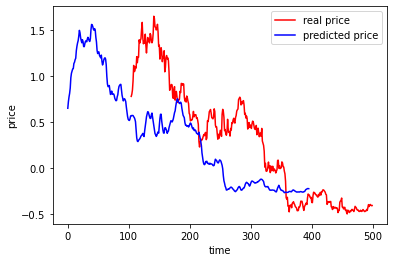

In [54]:
plt.figure()
plt.plot(y_test, color='red', label='real price')
plt.plot(y_pred, color='blue', label='predicted price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()
